In [1]:
import sys
# ① YOLOv5 루트 디렉토리를 PYTHONPATH에 추가 (실제 경로로 변경)
# sys.path.append('/path/to/yolov5')

import yaml
import cv2
import matplotlib.pyplot as plt
from utils.dataloaders import LoadRGBTImagesAndLabels

# ② hyp 파일 로드
with open('data/hyps/hyp.scratch-low.yaml') as f:
    hyp = yaml.safe_load(f)

# ③ mosaic 항상 적용하도록 설정
hyp['mosaic'] = 1.0
hyp.setdefault('mixup', 0.0)

# ④ 데이터셋 생성
dataset = LoadRGBTImagesAndLabels(
    path='datasets/kaist-rgbt/train-all-04.txt',  # 이미지 폴더 또는 txt 리스트 경로
    img_size=640,
    batch_size=16,
    augment=True,
    hyp=hyp,
    rect=False,
    cache_images=False,
    single_cls=True,
    stride=32,
    pad=0.0,
    image_weights=False,
    prefix='',
    rank=-1
)


is_train: True


Scanning datasets/kaist-rgbt/train-all-04.cache... 12538 images, 7009 backgrounds, 0 corrupt: 100%|██████████| 12538/12538 [00:00<?, ?it/s]


mosaic: True


for check mosaic, load rgbt
h: 512
w: 640
labels in mosaic part: [[    0.85312     0.41016    0.035937     0.11719           1]
 [    0.87969     0.41602    0.040625     0.13477           0]
 [    0.94687     0.43555     0.03125     0.11719           0]
 [     0.9625     0.41992    0.034375     0.12695           1]]
labels after padding: [[          0         821          41         844         101           1]
 [          0         838          44         864         113           0]
 [          0         881          54         901         114           0]
 [          0         891          46         913         111           1]]
h: 512
w: 640
labels in mosaic part: [[     0.8125     0.43164    0.034375    0.085938           0]]
labels after padding: [[          0        1435          52        1457          96           0]]
h: 512
w: 640
labels in mosaic part: []
labels after padding: []
h: 512
w: 640
labels in mosaic part: [[    0.87813     0.42773    0.067188     0.17773         

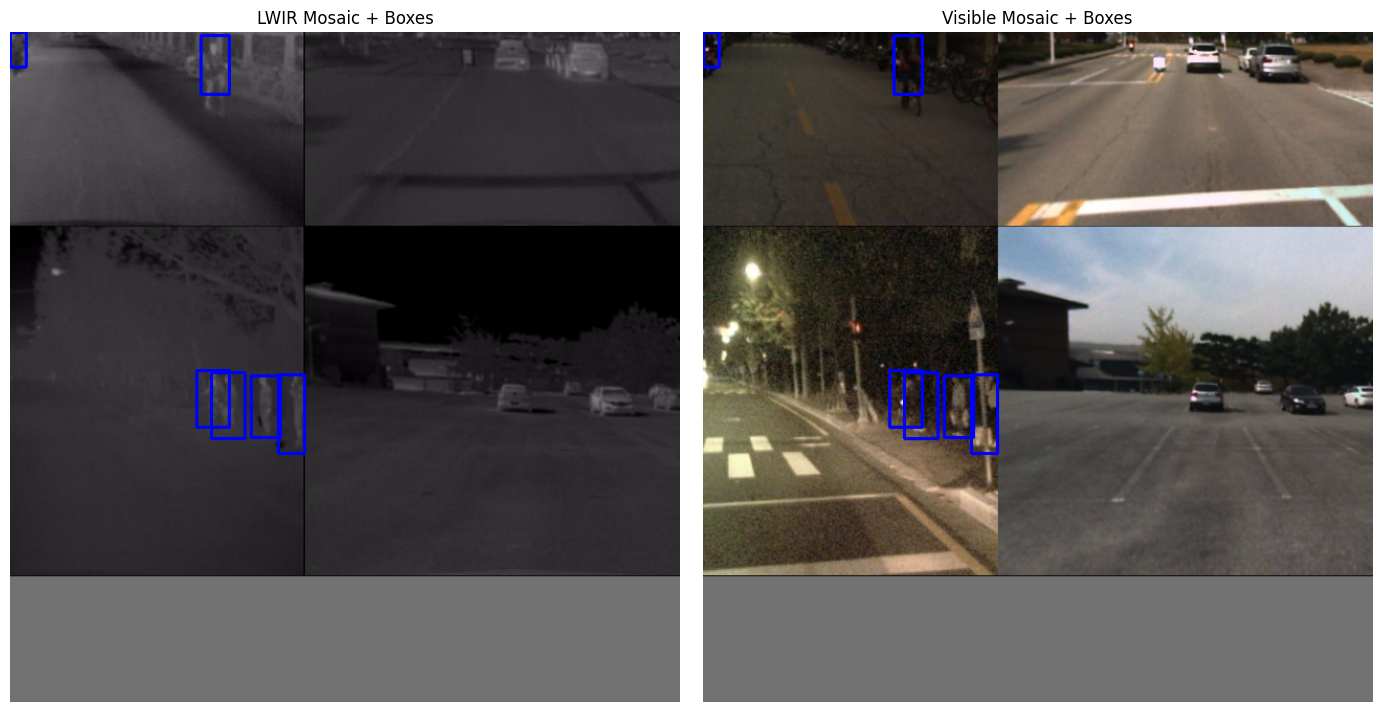

In [10]:
# ④ label이 3개 이상인 mosaic 샘플 인덱스 찾기
selected_idx = None
for idx in range(len(dataset)):
    # for check mosaic
    print("for check mosaic, load rgbt")
    (asdf, asdfasdf), lbls = dataset.load_mosaic_rgbt(idx)
    if len(lbls) >= 3:
        selected_idx = idx
        print(f"▶ 선택된 인덱스: {idx}, 라벨 개수: {len(lbls)}")
        break
    
print("for visualization image")
(img_lwir, img_vis), labels = dataset.load_mosaic_rgbt(selected_idx)
print("img_lwir size:", img_lwir.shape)
print("img_vis size:", img_vis.shape)

# ⑥ 박스 그리기 함수
def draw_boxes(img, labels, color=(255, 0, 0), thickness=2):
    for lbl in labels:
        x1, y1, x2, y2 = lbl[1:5].astype(int)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
    return img

# ⑦ 박스 그린 이미지 준비
mosaic_lwir = draw_boxes(img_lwir.copy(), labels)
mosaic_vis  = draw_boxes(img_vis.copy(), labels)

# ⑧ 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(cv2.cvtColor(mosaic_lwir, cv2.COLOR_BGR2RGB))
axes[0].set_title('LWIR Mosaic + Boxes')
axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(mosaic_vis, cv2.COLOR_BGR2RGB))
axes[1].set_title('Visible Mosaic + Boxes')
axes[1].axis('off')
plt.tight_layout()
plt.show()

In [3]:
import random
img_size = 640
s = img_size
yc, xc = (int(random.uniform(-x, 2 * s + x)) for x in [-img_size // 2, -img_size // 2])
print("yc, xc:", yc, xc)

yc, xc: 612 371


labels: [[          0     0.73906     0.46875     0.11094     0.40039]
 [          0     0.78281     0.49609     0.12188      0.4043]]
x1,y1: 473 240
x2,y2: 544 445
x1,y1: 501 254
x2,y2: 579 461


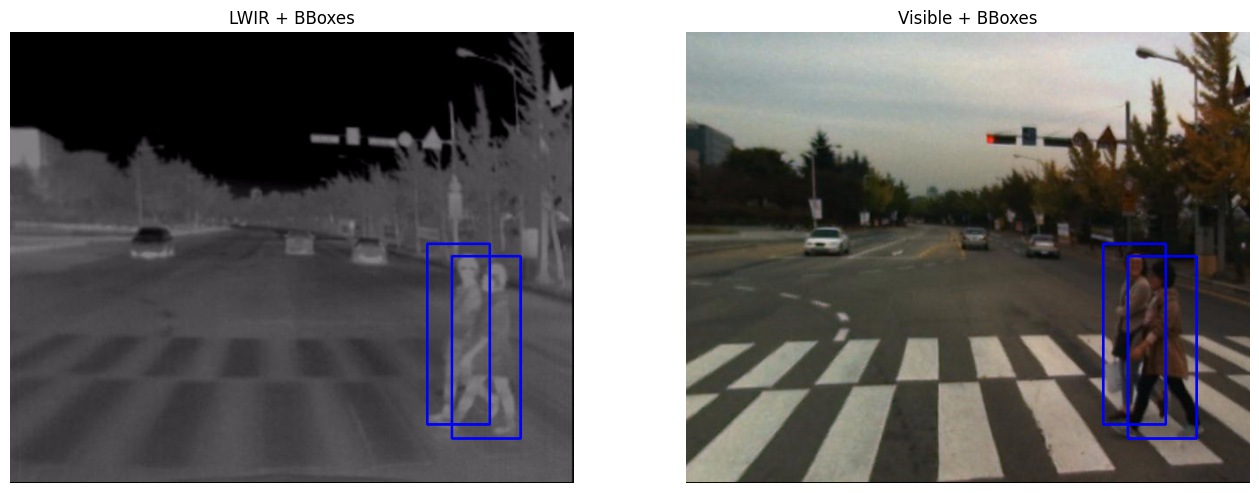

In [4]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_rgbt_with_boxes(img_lwir, img_vis, labels, class_names=None):
    """
    x, y: 중심 좌표 (normalized)
    w, h: 너비, 높이 (normalized)
    """
    img_lwir = img_lwir.copy()
    img_vis = img_vis.copy()
    h, w = img_lwir.shape[:2]  # 이미지 크기

    for label in labels:
        cls, x_c, y_c, box_w, box_h = label

        # xywhn → xyxy
        x1 = int((x_c) * w)
        y1 = int((y_c) * h)
        x2 = int((x_c + box_w) * w)
        y2 = int((y_c + box_h) * h)

        print("x1,y1:",x1, y1)
        print("x2,y2:", x2, y2)

        # 시각화: 박스 그리기
        cv2.rectangle(img_lwir, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.rectangle(img_vis, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # 클래스 이름 표시 (옵션)
        if class_names:
            label_text = class_names[int(cls)]
            cv2.putText(img_lwir, label_text, (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
            cv2.putText(img_vis, label_text, (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # 두 이미지 나란히 시각화
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.title("LWIR + BBoxes")
    plt.imshow(cv2.cvtColor(img_lwir, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("Visible + BBoxes")
    plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


# 이미지 불러오기
img_lwir = cv2.imread("datasets/kaist-rgbt/train/images/lwir/set01_V005_I00195.jpg")     # BGR
img_vis  = cv2.imread("datasets/kaist-rgbt/train/images/visible/set01_V005_I00195.jpg")  # BGR

# 라벨 불러오기
labels = np.loadtxt("datasets/kaist-rgbt/train/labels/set01_V005_I00195.txt")  # [class, x, y, w, h]
print("labels:", labels[:,0:5])

# 클래스 이름 (옵션)
class_names = ["person", "cyclist", "other"]

# 시각화
plot_rgbt_with_boxes(img_lwir, img_vis, labels[:,0:5])
